<a href="https://colab.research.google.com/github/AtharvaTambat/WnCC-SoC-2022-QML/blob/main/Shor's_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Shor's Algorithm**



## **1. Importing necessary Libraries**

In [4]:
import math
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
from fractions import Fraction
from tabulate import tabulate
from statistics import mode
from numpy import random


# Use Aer's qasm_simulator
simulator = AerSimulator()

## **2. Running some checks before running the period-finding algorithm**

In [13]:
def gcd(m,n):
    if m< n:
        (m,n) = (n,m)
    if(m%n) == 0:
        return n
    else:
        return (gcd(n, m % n)) 

N = 15 # Number to be factorized
a = 0 # Number ransomly chosen from the range [0,N) for Shor's algorithm 

# Pre-processing required before running period finding algorithm 
if (N%2==0):
  print("The factors of %i are %i and %i" % (N,2,N/2))
else:
  a = random.choice(range(1,N)) # randomly choosing a in [0, N-1) such that gcd(a,N) = 1

if gcd(a,N)>1:
  print("The factors of %i are %i and %i" % (N,a,N/a))

print("The value of a is:", a)

The value of a is: 7


## **3. The period finding algorithm**

### **3.1 The circuit**

In [14]:
# Implementing the transformation |y> -----> |(a^j)y mod N> for N = 15, for initial value of y = 1
def axmod15(a, power):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

# Function for computing Inverse Quantum Fourier Transform for first n qubits
def inverse_qft(n):
  U = QuantumCircuit(10)

  for i in range(int(n/2)):
    U.swap(i,n-i-1)

  for i in range(n):
    for j in range(0,i):
     # U.cp(-math.pi/(2**(i-j)),n-1-j,n-i-1)
   # U.h(n-i-1) 
       U.cp(-math.pi/(2**(i-j)),j,i)
    U.h(i)  

  U = U.to_gate()
  U.name = "QFT_dagger"
  return U


# Since implementation of Shor's algorithm for an L bit number requires at least 2L + 1 qubits in 1st Register and 4 bits in the second register
t = 10
qc = QuantumCircuit(t + 4, t)

for i in range (10):
  qc.h(i)

qc.x(13) # To initialize the 2nd Register to the state |1>

qc.barrier()

# Adding the controlled U (|y> -----> |(a^j)y mod N>) gates 

for q in range(10):
    qc.append(axmod15(a, 2**q), [q] +[j + 10 for j in range(4)])
qc.barrier()

qc.append(inverse_qft(10),range(10))

qc.barrier()

qc.measure(range(10),range(10))


qc.draw(fold = -1)

┌───┐ ░                                                                                                                                                                 ░ ┌─────────────┐ ░ ┌─┐                           
 q_0: ┤ H ├─░────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤0            ├─░─┤M├───────────────────────────
      ├───┤ ░        │                                                                                                                                                        ░ │             │ ░ └╥┘┌─┐                        
 q_1: ┤ H ├─░────────┼──────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤1            ├─░──╫─┤M├────────────────────────
      ├───┤ ░        │              │                                                                                                                                         ░ │             │ ░  ║ └╥┘┌─┐                     
 q_2: ┤ H ├─░────────┼──────────────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤2            ├─░──╫──╫─┤M├─────────────────────
      ├───┤ ░        │              │              │                                                                                                                          ░ │             │ ░  ║  ║ └╥┘┌─┐                  
 q_3: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤3            ├─░──╫──╫──╫─┤M├──────────────────
      ├───┤ ░        │              │              │              │                                                                                                           ░ │             │ ░  ║  ║  ║ └╥┘┌─┐               
 q_4: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────────────────────────░─┤4            ├─░──╫──╫──╫──╫─┤M├───────────────
      ├───┤ ░        │              │              │              │              │                                                                                            ░ │  QFT_dagger │ ░  ║  ║  ║  ║ └╥┘┌─┐            
 q_5: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■────────────────────────────────────────────────────────────────────────────░─┤5            ├─░──╫──╫──╫──╫──╫─┤M├────────────
      ├───┤ ░        │              │              │              │              │               │                                                                            ░ │             │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐         
 q_6: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■────────────────────────────────────────────────────────────░─┤6            ├─░──╫──╫──╫──╫──╫──╫─┤M├─────────
      ├───┤ ░        │              │              │              │              │               │               │                                                            ░ │             │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q_7: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■───────────────────────────────────────────░─┤7            ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├──────
      ├───┤ ░        │              │              │              │              │               │               │                │                                           ░ │             │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_8: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────┼────────────────■──────────────────────────░─┤8   

### **3.2 Running the circuit**

Total count for possible combinations of output are:  {'0000000000': 246, '1000000000': 252, '0100000000': 279, '1100000000': 247}


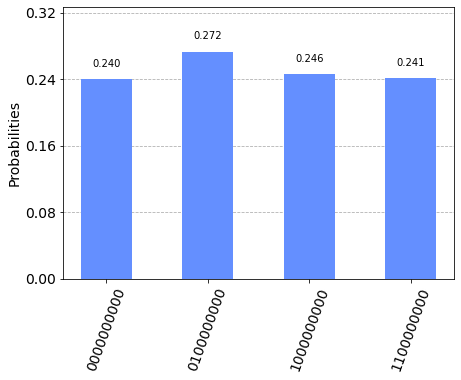

In [15]:
# Compiling the circuit
compiled_circuit = transpile(qc, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=1024)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(qc)
print("Total count for possible combinations of output are: ", counts)

# Plot a histogram
plot_histogram(counts)

### **3.3 Guessing the denominator of the phase $\frac{s}{r}$ obtained**

In [16]:
output = list(counts.keys())

# Function to convert t-bit binary number to decimal number
def Bool_to_Int(b): # b - Binary number
  num = 0
  for i in range(t):
    num = num + (2**i)*(b%10)
    b = int(b/10)
  return(num)

# To tabulate all the possible values of reduced fractions s/r for possible outputs of the 1st register
data = []
r_values = []

for i in output:
  row = []
  row.append(int(i))

  num = Bool_to_Int(int(i)) # num stores the numerator of the fraction s/r
  row.append(num)

  frac = num/(2**t)
  row.append(frac) # adds the decimal value of s/r

  frac_reduced = Fraction(frac).limit_denominator(15)
  row.append(f"{frac_reduced.numerator}/{frac_reduced.denominator}")

  row.append(frac_reduced.denominator)
  r_values.append(frac_reduced.denominator)

  data.append(row)


print (tabulate(data, headers=["Binary Output", "Decimal Equivalent", "Value of s/r", "Reduced fraction (s/r)", "Possible value of r"]))

  Binary Output    Decimal Equivalent    Value of s/r  Reduced fraction (s/r)      Possible value of r
---------------  --------------------  --------------  ------------------------  ---------------------
              0                     0            0     0/1                                           1
     1000000000                   512            0.5   1/2                                           2
      100000000                   256            0.25  1/4                                           4
     1100000000                   768            0.75  3/4                                           4


## **4. Classical Algorithm for finding the factors once the period of $f(x) = a^{x} (mod N)$ is obtained**

In [17]:
r = mode(r_values) # Extracts the value of r which is guessed the most number of times - which is hopefully.....the correct value of the period

print("The period of the function %i^x (mod %i) is:" % (a,N), r)

# Shor's classical algorithm for factor finding
if (r%2 == 0) & ((a**(r/2) +1)%N != 0):
  num1 = gcd(int(a**(r/2) +1), N)
  num2 = gcd(int(a**(r/2) -1), N)


  if (N%num1 == 0):
    print("The factors of",N,"are %i and %i" % (num1, N/num1))
  elif (N%num2 == 0):
    print("The factors of",N,"are %i and %i" % (num2, N/num2))
  else:
    print("Program failed to factorize %i, run again" % (N))
  
else:
  print("Program failed to factorize %i, run again" % (N))



The period of the function 7^x (mod 15) is: 4
The factors of 15 are 5 and 3
